## Challenge: 
### Devise a signal to noise metric that best aligns with expert annotation. 
#### The metric can be applied to an averaged image of an ophys FOV, to frames of the ophys movie, or to cell traces. 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
# must be on dev branch of visual_behavior_analysis: 
# https://github.com/AllenInstitute/visual_behavior_analysis/tree/dev 
import visual_behavior.data_access.utilities as utilities
import visual_behavior.data_access.loading as loading

### select experiment to work with

In [4]:
experiments_to_work_with = [881003493,  903485710,  906910616,  959389440,  963391867,
                            964615771,  965980152,  967906375,  969430840,  972233183,
                            974358971,  974384470, 1038382406, 1042126970, 1052609309]

In [5]:
experiment_id = experiments_to_work_with[7]
experiment_id

967906375

### load average image

This loads an image of the FOV, averaged over 16 frames

In [6]:
def get_average_depth_image(experiment_id):
    """
    quick and dirty function to load 16x depth image from lims
    file path location depends on whether it is scientifica or mesoscope, and which version of the pipeline was run
    function iterates through all possible options of file locations
    """
    import visual_behavior.data_access.utilities as utilities
    import matplotlib.pyplot as plt
    
    expt_dir = utilities.get_ophys_experiment_dir(utilities.get_lims_data(experiment_id))
    session_dir = utilities.get_ophys_session_dir(utilities.get_lims_data(experiment_id))
    session_id = utilities.get_ophys_session_id_from_ophys_experiment_id(experiment_id)
    
    # try all combinations of potential file path locations...
    if os.path.isfile(os.path.join(session_dir, str(experiment_id)+'_averaged_depth.tif')):
        im = plt.imread(os.path.join(session_dir, str(experiment_id)+'_averaged_depth.tif'))
    elif os.path.isfile(os.path.join(session_dir, str(experiment_id)+'_depth.tif')):
        im = plt.imread(os.path.join(session_dir, str(experiment_id)+'_depth.tif'))
    elif os.path.isfile(os.path.join(session_dir, str(session_id)+'_averaged_depth.tif')):
        im = plt.imread(os.path.join(session_dir, str(session_id)+'_averaged_depth.tif'))
    elif os.path.isfile(os.path.join(expt_dir, str(experiment_id)+'_averaged_depth.tif')):
        im = plt.imread(os.path.join(expt_dir, str(experiment_id)+'_averaged_depth.tif'))
    elif os.path.isfile(os.path.join(expt_dir, str(experiment_id)+'_depth.tif')):
        im = plt.imread(os.path.join(expt_dir, str(experiment_id)+'_depth.tif'))
    else: 
        print('problem for', experiment_id)
        print(session_dir)
    return im

In [7]:
im = loading.get_average_depth_image(experiment_id)

Getting all ophys sessions. This might take a while.


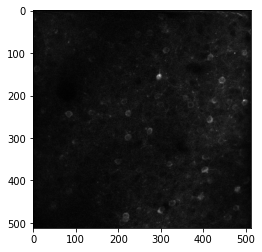

In [8]:
plt.imshow(im, cmap='gray')

### load full motion corrected movie

In [9]:
movie = loading.load_motion_corrected_movie(experiment_id)
movie.shape

(48292, 512, 512)

In [10]:
movie_average = np.nanmean(movie, axis=0)

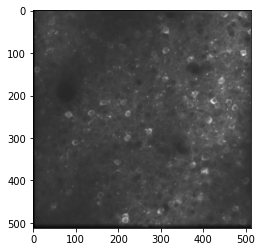

In [11]:
plt.imshow(movie_average, cmap='gray')

### load dF/F traces

In [12]:
dataset = loading.get_ophys_dataset(experiment_id)

loading data for 967906375_477052_191015_VISp_0_cre_line_unknown_MESO.1_behavior_174


In [13]:
traces = dataset.dff_traces

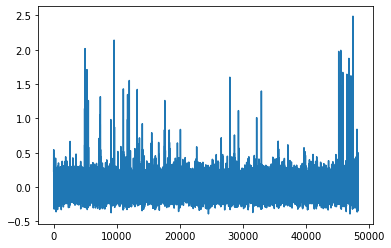

In [14]:
# plot trace for one cell
plt.plot(traces.iloc[0].dff)

### apply SNR metric

In [15]:
# insert your SNR metric function here

In [16]:
def assign_snr(dataset):
    for idx,row in dataset.dff_traces.iterrows():
        dff = row['dff'][1000:-1000] # avoid first/last 100 datapoints to avoid spurious dff data at start/finish of recording
        dataset.dff_traces.at[idx,'snr_99p_over_std'] = np.percentile(dff,99)/np.std(dff)
        dataset.dff_traces.at[idx,'peak_over_std'] = np.max(dff)/np.std(dff)
        dataset.dff_traces.at[idx,'snr_mu_over_std'] = np.mean(dff)/np.std(dff)

In [17]:
def get_best_snr(dataset):
    assign_snr(dataset)
    return dataset.dff_traces['peak_over_std'].max()

In [18]:
def plot_snr_examples(dataset):
    assign_snr(dataset)
    sorted_dff = dataset.dff_traces.sort_values(by='peak_over_std')
    
    indices = [0, np.int(np.floor(len(sorted_dff)/2)), len(sorted_dff)-1]
    
    fig,ax=plt.subplots(3,1,figsize=(8,4),sharex=True)
    ax[0].plot(sorted_dff.iloc[indices[0]]['dff'])
    ax[1].plot(sorted_dff.iloc[indices[1]]['dff'])
    ax[2].plot(sorted_dff.iloc[indices[2]]['dff'])
    
    labels = ['low','medium','high']
    for i in range(3):
        ax[i].set_title('{} snr example, peak_over_std = {:0.4f}'.format(labels[i], sorted_dff.iloc[indices[i]]['peak_over_std']))
    
    fig.tight_layout()
    fig.suptitle('experiment_id = {}'.format(dataset.ophys_experiment_id))
    return fig,ax

loading data for 881003493_451787_190604_VISl_0_Slc17a7-IRES2-Cre_MESO.1_behavior_225
loading data for 903485710_456915_190710_VISp_0_Slc17a7-IRES2-Cre_MESO.1_behavior_375
loading data for 906910616_456915_190715_VISp_0_Slc17a7-IRES2-Cre_MESO.1_behavior_375
loading data for 959389440_472271_191001_VISam_0_cre_line_unknown_MESO.1_behavior_275
loading data for 963391867_479458_191008_VISp_375_cre_line_unknown_2P4_behavior_1imagesB
loading data for 964615771_477052_191009_VISl_0_cre_line_unknown_MESO.1_behavior_175
loading data for 965980152_477052_191011_VISl_0_cre_line_unknown_MESO.1_behavior_171
loading data for 967906375_477052_191015_VISp_0_cre_line_unknown_MESO.1_behavior_174
loading data for 969430840_481295_191016_VISp_0_cre_line_unknown_MESO.1_behavior_179
loading data for 972233183_484627_191023_VISp_0_Slc17a7-IRES2-Cre_MESO.1_behavior_273
loading data for 974358971_484627_191029_VISp_0_Slc17a7-IRES2-Cre_MESO.1_behavior_179
loading data for 974384470_479426_191030_VISp_175_cre_l

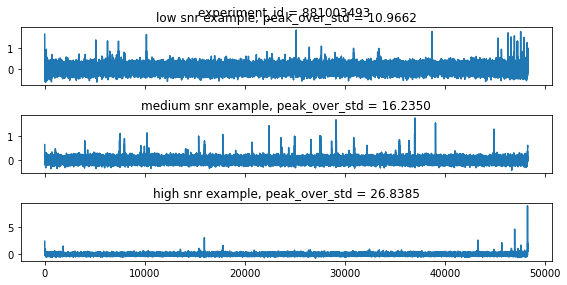

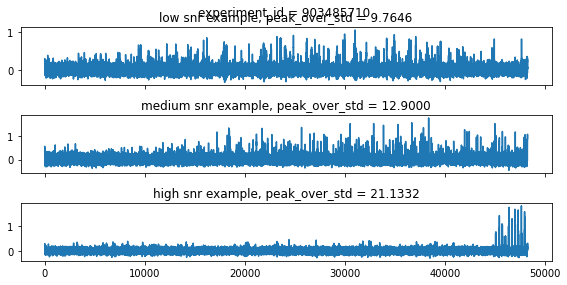

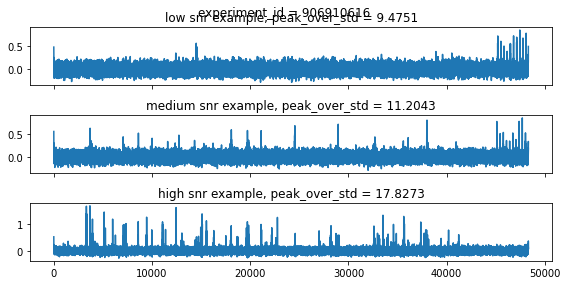

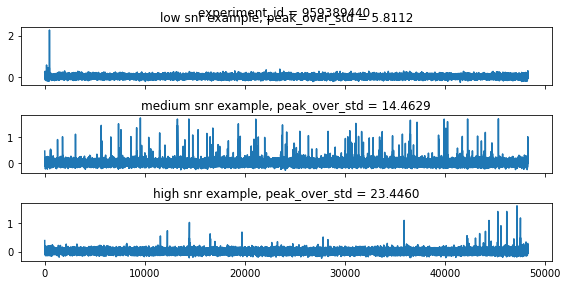

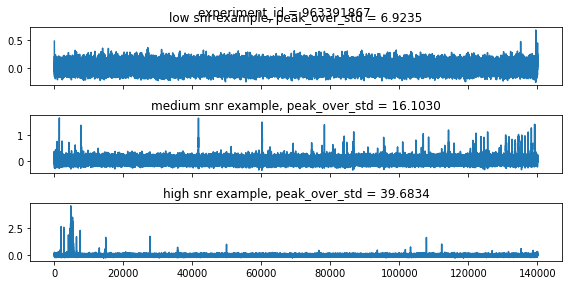

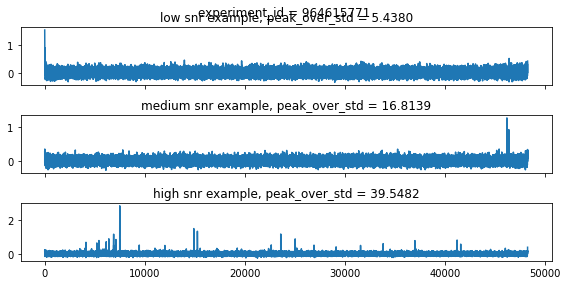

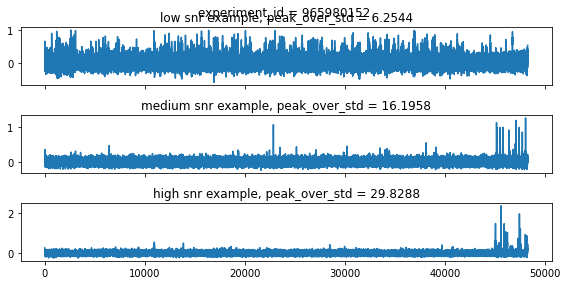

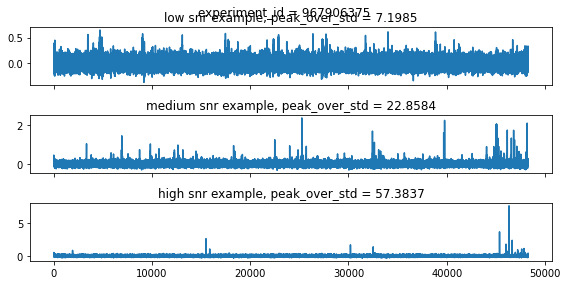

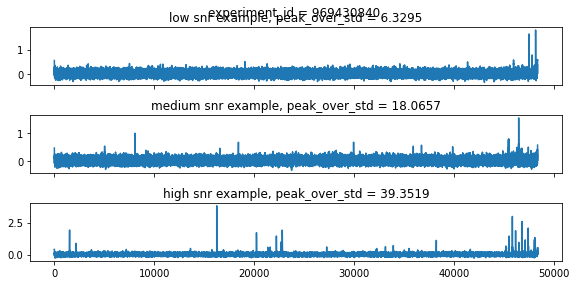

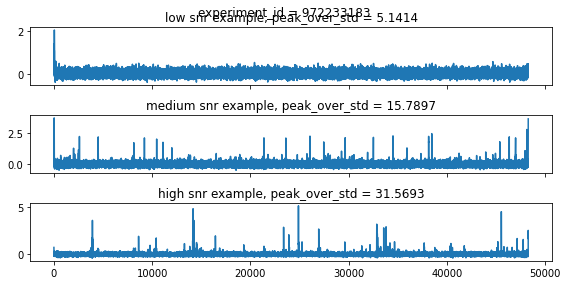

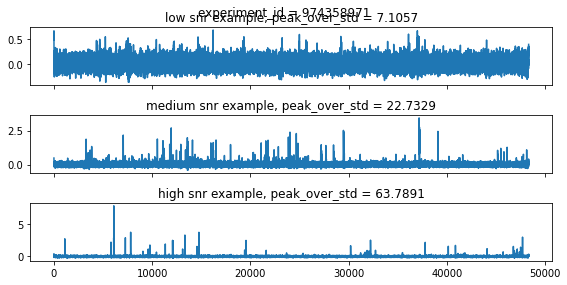

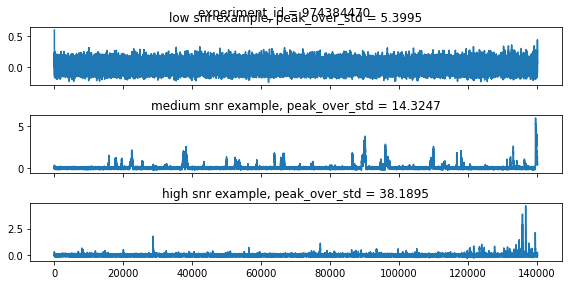

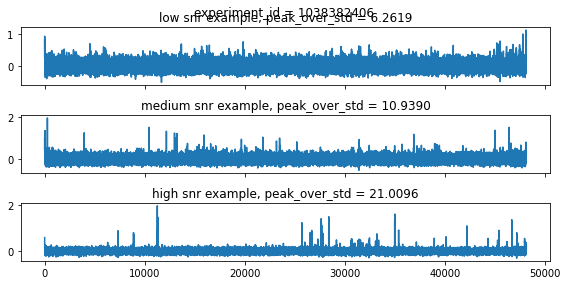

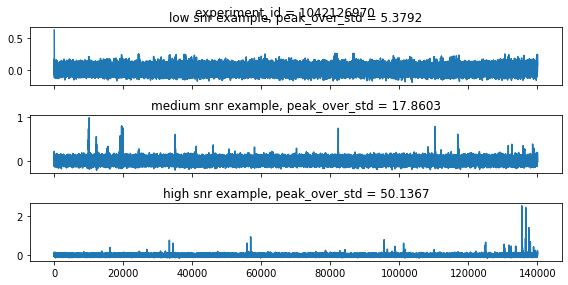

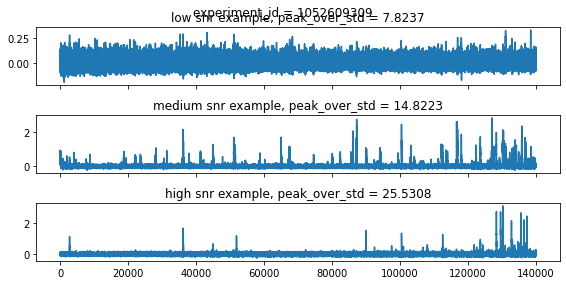

In [19]:
for experiment_id in experiments_to_work_with:
    dataset = loading.get_ophys_dataset(experiment_id)
    fig,ax=plot_snr_examples(dataset)


## Sort the example experiments by the peak_over_std metric

In [20]:
examples = []
for experiment_id in experiments_to_work_with:
    dataset = loading.get_ophys_dataset(experiment_id)
    assign_snr(dataset)
    examples.append({
        'ophys_experiment_id':experiment_id,
        'peak_over_std_max': dataset.dff_traces['peak_over_std'].max()
    })
answer = pd.DataFrame(examples).sort_values(by='peak_over_std_max')

loading data for 881003493_451787_190604_VISl_0_Slc17a7-IRES2-Cre_MESO.1_behavior_225
loading data for 903485710_456915_190710_VISp_0_Slc17a7-IRES2-Cre_MESO.1_behavior_375
loading data for 906910616_456915_190715_VISp_0_Slc17a7-IRES2-Cre_MESO.1_behavior_375
loading data for 959389440_472271_191001_VISam_0_cre_line_unknown_MESO.1_behavior_275
loading data for 963391867_479458_191008_VISp_375_cre_line_unknown_2P4_behavior_1imagesB
loading data for 964615771_477052_191009_VISl_0_cre_line_unknown_MESO.1_behavior_175
loading data for 965980152_477052_191011_VISl_0_cre_line_unknown_MESO.1_behavior_171
loading data for 967906375_477052_191015_VISp_0_cre_line_unknown_MESO.1_behavior_174
loading data for 969430840_481295_191016_VISp_0_cre_line_unknown_MESO.1_behavior_179
loading data for 972233183_484627_191023_VISp_0_Slc17a7-IRES2-Cre_MESO.1_behavior_273
loading data for 974358971_484627_191029_VISp_0_Slc17a7-IRES2-Cre_MESO.1_behavior_179
loading data for 974384470_479426_191030_VISp_175_cre_l

In [21]:
answer.reset_index(drop=True).reset_index().rename(columns={'index':'snr_rank_low_to_high'}).to_csv('/home/dougo/OneDrive/2020.01.14_SNR_table_doug.csv')

In [22]:
answer

,ophys_experiment_id,peak_over_std_max
2,906910616,17.827266
12,1038382406,21.009650
1,903485710,21.133237
3,959389440,23.446041
14,1052609309,25.530799
0,881003493,26.838544
6,965980152,29.828803
9,972233183,31.569309
11,974384470,38.189538
8,969430840,39.351890


## show average projections, sorted by peak_over_std metric

unable to locate analysis folder for experiment 906910616.0 in //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/visual_behavior_production_analysis
creating new analysis folder


/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()


loading data for 906910616.0_456915_190715_VISp_375_Camk2a-tTA_MESO.1_OPHYS_4_images_B


/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()


unable to locate analysis folder for experiment 1038382406.0 in //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/visual_behavior_production_analysis
creating new analysis folder
loading data for 1038382406.0_513630_200724_VISam_275_Camk2a-tTA_MESO.1_OPHYS_1_images_G
unable to locate analysis folder for experiment 903485710.0 in //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/visual_behavior_production_analysis
creating new analysis folder


/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()


loading data for 903485710.0_456915_190710_VISp_375_Camk2a-tTA_MESO.1_OPHYS_1_images_A
unable to locate analysis folder for experiment 959389440.0 in //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/visual_behavior_production_analysis
creating new analysis folder


/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()


loading data for 959389440.0_472271_191001_VISam_275_Camk2a-tTA_MESO.1_OPHYS_1_images_G
unable to locate analysis folder for experiment 1052609309.0 in //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/visual_behavior_production_analysis
creating new analysis folder


/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()


loading data for 1052609309.0_523927_200924_VISp_175_Vip-IRES-Cre_CAM2P.4_OPHYS_1_images_A
unable to locate analysis folder for experiment 881003493.0 in //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/visual_behavior_production_analysis
creating new analysis folder


/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()


loading data for 881003493.0_451787_190604_VISl_225_Camk2a-tTA_MESO.1_OPHYS_1_images_A
unable to locate analysis folder for experiment 965980152.0 in //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/visual_behavior_production_analysis
creating new analysis folder


/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()


loading data for 965980152.0_477052_191011_VISl_171_Camk2a-tTA_MESO.1_OPHYS_3_images_G
unable to locate analysis folder for experiment 972233183.0 in //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/visual_behavior_production_analysis
creating new analysis folder


/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()


loading data for 972233183.0_484627_191023_VISp_273_Camk2a-tTA_MESO.1_OPHYS_2_images_A_passive
unable to locate analysis folder for experiment 974384470.0 in //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/visual_behavior_production_analysis
creating new analysis folder


/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()


loading data for 974384470.0_479426_191030_VISp_175_Camk2a-tTA_CAM2P.5_OPHYS_3_images_A
unable to locate analysis folder for experiment 969430840.0 in //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/visual_behavior_production_analysis
creating new analysis folder


/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()


loading data for 969430840.0_481295_191016_VISp_179_Camk2a-tTA_MESO.1_OPHYS_3_images_G
unable to locate analysis folder for experiment 964615771.0 in //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/visual_behavior_production_analysis
creating new analysis folder


/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()


loading data for 964615771.0_477052_191009_VISl_175_Camk2a-tTA_MESO.1_OPHYS_1_images_G
unable to locate analysis folder for experiment 963391867.0 in //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/visual_behavior_production_analysis
creating new analysis folder


/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()


loading data for 963391867.0_479458_191008_VISp_375_Camk2a-tTA_CAM2P.4_OPHYS_1_images_B
unable to locate analysis folder for experiment 1042126970.0 in //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/visual_behavior_production_analysis
creating new analysis folder


/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()


loading data for 1042126970.0_513626_200810_VISp_375_Camk2a-tTA_CAM2P.3_OPHYS_1_images_B
unable to locate analysis folder for experiment 967906375.0 in //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/visual_behavior_production_analysis
creating new analysis folder


/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()


loading data for 967906375.0_477052_191015_VISp_174_Camk2a-tTA_MESO.1_OPHYS_4_images_H
unable to locate analysis folder for experiment 974358971.0 in //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/visual_behavior_production_analysis
creating new analysis folder


/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()


loading data for 974358971.0_484627_191029_VISp_179_Camk2a-tTA_MESO.1_OPHYS_4_images_B


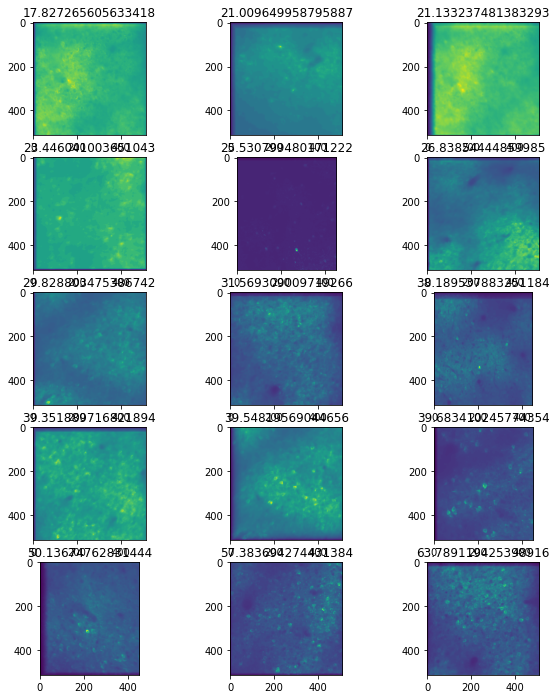

In [23]:
fig,ax=plt.subplots(5,3,figsize=(10,12))
for idx,row in answer.reset_index().iterrows():
    dataset = loading.get_ophys_dataset(row['ophys_experiment_id'])
    ax.flatten()[idx].imshow(dataset.average_projection)
    ax.flatten()[idx].set_title(row['peak_over_std_max'])

## show max projections, sorted by peak_over_std metric

loading data for 906910616.0_456915_190715_VISp_375_Camk2a-tTA_MESO.1_OPHYS_4_images_B
loading data for 1038382406.0_513630_200724_VISam_275_Camk2a-tTA_MESO.1_OPHYS_1_images_G
loading data for 903485710.0_456915_190710_VISp_375_Camk2a-tTA_MESO.1_OPHYS_1_images_A
loading data for 959389440.0_472271_191001_VISam_275_Camk2a-tTA_MESO.1_OPHYS_1_images_G
loading data for 1052609309.0_523927_200924_VISp_175_Vip-IRES-Cre_CAM2P.4_OPHYS_1_images_A
loading data for 881003493.0_451787_190604_VISl_225_Camk2a-tTA_MESO.1_OPHYS_1_images_A
loading data for 965980152.0_477052_191011_VISl_171_Camk2a-tTA_MESO.1_OPHYS_3_images_G
loading data for 972233183.0_484627_191023_VISp_273_Camk2a-tTA_MESO.1_OPHYS_2_images_A_passive
loading data for 974384470.0_479426_191030_VISp_175_Camk2a-tTA_CAM2P.5_OPHYS_3_images_A
loading data for 969430840.0_481295_191016_VISp_179_Camk2a-tTA_MESO.1_OPHYS_3_images_G
loading data for 964615771.0_477052_191009_VISl_175_Camk2a-tTA_MESO.1_OPHYS_1_images_G
loading data for 963391867.

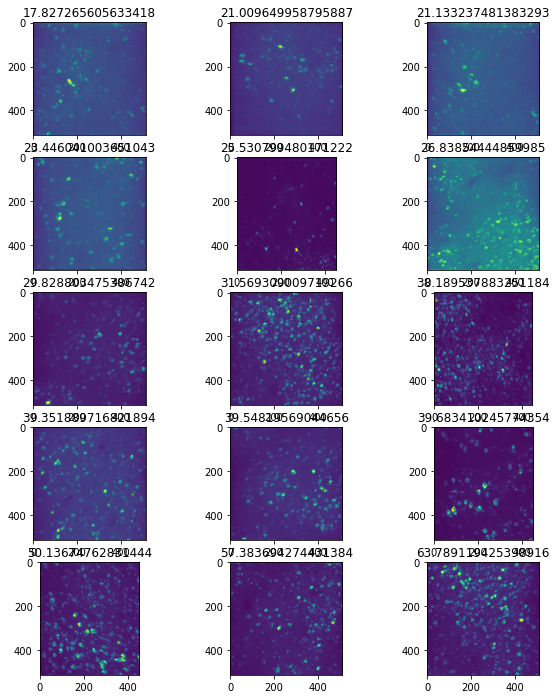

In [24]:
fig,ax=plt.subplots(5,3,figsize=(10,12))
for idx,row in answer.reset_index().iterrows():
    dataset = loading.get_ophys_dataset(row['ophys_experiment_id'])
    ax.flatten()[idx].imshow(dataset.max_projection)
    ax.flatten()[idx].set_title(row['peak_over_std_max'])

In [25]:
dir(dataset)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_analysis_folder',
 '_cell_specimen_table',
 '_corrected_fluorescence_traces',
 '_dff_traces',
 '_eye_tracking',
 '_eye_tracking_dilation_frames',
 '_eye_tracking_z_threshold',
 '_get_events',
 '_get_param_names',
 '_get_param_signatures',
 '_get_param_type_annotations',
 '_get_roi_masks_by_cell_roi_id',
 '_ignore',
 '_include_invalid_rois',
 '_licks',
 '_metadata',
 '_motion_correction',
 '_ophys_timestamps',
 '_raw_running_data_df',
 '_raw_running_speed',
 '_rewards',
 '_running_data_df',
 '_running_speed',
 '_segmentation_mask_image',
 '_stimulus_presentations',
 '_stimulus_templates',
 '_stimulus_timestamps',
 '_task

In [26]:
movie = loading.load_motion_corrected_movie(974358971)

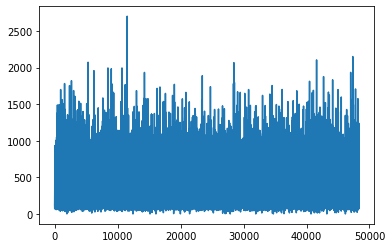

In [27]:
fig,ax=plt.subplots()
ax.plot(movie[:,250,250])

In [28]:
# fig,ax=plt.subplots()
m = movie[-3000:,:,:]

In [29]:
np.shape(m)

(3000, 512, 512)

In [30]:
def get_peak_over_std(v):
    return np.nanmax(v)/np.nanstd(v)

In [31]:
%%time
ans = np.apply_along_axis(get_peak_over_std, 0, m)

/home/dougo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


CPU times: user 34.6 s, sys: 0 ns, total: 34.6 s
Wall time: 34.6 s


In [32]:
dataset.get_average_projection()

Image(data=array([[0.        , 0.        , 0.        , ..., 0.00392157, 0.        ,
        0.        ],
       [0.        , 0.        , 0.00392157, ..., 0.00392157, 0.00392157,
        0.00392157],
       [0.00392157, 0.00392157, 0.00784314, ..., 0.01176471, 0.00784314,
        0.00784314],
       ...,
       [0.00392157, 0.00392157, 0.01568628, ..., 0.07843138, 0.07450981,
        0.07058824],
       [0.00392157, 0.00392157, 0.01176471, ..., 0.09411765, 0.08627451,
        0.08627451],
       [0.00392157, 0.00392157, 0.01568628, ..., 0.07450981, 0.07058824,
        0.06666667]], dtype=float32), spacing=(0.00078, 0.00078), unit='mm')

OSError: //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/visual_behavior_production_analysis contains multiple possible analysis folders: ['974358971_484627_191029_VISp_0_Slc17a7-IRES2-Cre_MESO.1_behavior_179', '974358971.0_484627_191029_VISp_179_Camk2a-tTA_MESO.1_OPHYS_4_images_B']

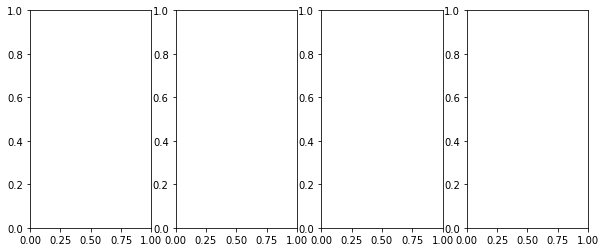

In [39]:
def plot_metric(oeid, ans):
    fig,ax=plt.subplots(1,4,figsize=(10,4))
    
    dataset = loading.get_ophys_dataset(oeid)
    ax[0].imshow(dataset.get_max_projection())
    ax[1].imshow(dataset.get_average_projection())
    ax[2].imshow(ans)
    ax[3].hist(ans.flatten(),bins=np.arange(0,np.nanmax(ans),0.1));
    ax[3].set_title('mean = {:0.3f}, 99p = {:0.3f}'.format(np.nanmean(ans), np.nanpercentile(ans,99)))
    ax[2].set_title('oeid = {}'.format(oeid))
    fig.tight_layout()
plot_metric(int(974358971), ans)

In [40]:
oeid = 974358971
loading.get_ophys_dataset(oeid)

OSError: //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/visual_behavior_production_analysis contains multiple possible analysis folders: ['974358971_484627_191029_VISp_0_Slc17a7-IRES2-Cre_MESO.1_behavior_179', '974358971.0_484627_191029_VISp_179_Camk2a-tTA_MESO.1_OPHYS_4_images_B']

In [35]:
def apply_metric(oeid):
    movie = loading.load_motion_corrected_movie(oeid)
    end_of_movie = movie[-3000:,:,:]
    ans = np.apply_along_axis(get_peak_over_std, 0, end_of_movie)
    plot_metric(oeid, ans)
    return {'oeid':oeid, 'mean':np.nanmean(ans), '95p':np.nanpercentile(ans,95), '99p':np.nanpercentile(ans,99)}

In [36]:
from multiprocessing import Pool

In [37]:
with Pool(32) as pool:
    all_ans = pool.map(apply_metric, experiments_to_work_with)

/home/dougo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/home/dougo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/home/dougo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/home/dougo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/home/dougo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/home/dougo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/home/dougo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/home/dougo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: Runt

OSError: //allen/programs/braintv/workgroups/nc-ophys/visual_behavior/visual_behavior_production_analysis contains multiple possible analysis folders: ['974358971_484627_191029_VISp_0_Slc17a7-IRES2-Cre_MESO.1_behavior_179', '974358971.0_484627_191029_VISp_179_Camk2a-tTA_MESO.1_OPHYS_4_images_B']

In [ ]:
pd.DataFrame(all_ans).sort_values(by='99p')

In [ ]:
answer